In [44]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

In [46]:
%matplotlib inline

In [47]:
TEXT_COLOUR = {
    'PURPLE':'\033[95m',
    'CYAN':'\033[96m',
    'DARKCYAN':'\033[36m',
    'BLUE':'\033[94m',
    'GREEN':'\033[92m',
    'YELLOW':'\033[93m',
    'RED':'\033[91m',
    'BOLD':'\033[1m',
    'UNDERLINE':'\033[4m',
    'END':'\033[0m'
}

def print_bold(*msgs):
    print(TEXT_COLOUR['BOLD'])
    print(*msgs)
    print(TEXT_COLOUR['END'])

def print_green(*msgs):
    print(TEXT_COLOUR['GREEN'])
    print(*msgs)
    print(TEXT_COLOUR['END'])

def print_error(*msgs):
    print(TEXT_COLOUR['RED'])
    print(*msgs)
    print(TEXT_COLOUR['END'])

def wrap_green(msg):
    return TEXT_COLOUR['GREEN'] + msg + TEXT_COLOUR['END']

def wrap_red(msg):
    return TEXT_COLOUR['RED'] + msg + TEXT_COLOUR['END']

def up_down_str(val):
    msg = str(val)
    if val > 0:
        msg = wrap_green(msg)
    elif val < 0:
        msg = wrap_red(msg)
    return msg

In [48]:
exp='bert-large'
num_layers = 24

In [49]:
tasks = ["CoLA","SST-2","MRPC","STS-B","QQP","MNLI", "MNLI-MM", "QNLI", "RTE"]

metrics = {
    "CoLA":["mcc"],
    "MNLI":["acc"],
    "MNLI-MM":["acc"],
    "MRPC":["f1"],
    "QNLI":["acc"],
    "QQP":["f1"],
    "RTE":["acc"],
    "SST-2":["acc"],
    "STS-B":["spearmanr"],
    "WNLI":["acc"] #temp
}

reported_in_paper = {
    "CoLA":0.00,
    "MNLI":0.00,
    "MNLI-MM":0.0,
    "MRPC":0.00,
    "QNLI":0.00,
    "QQP":0.00,
    "RTE":0.00,
    "SST-2":0.00,
    "STS-B":0.00,
    "WNLI":0.00
}

In [50]:

def get_average_val(lines):
    reported = []
    for line in lines:
        print('\t', line)
        val = float(line.split('\t')[1])
        if val != 0:
            reported.append(val)
    out = 0
    if len(reported) != 0:
        reported.sort(reverse = True)
        candidates = [reported[0]]
        for j in range(1, len(reported)):
            if reported[j] > 0.9 * reported[0]:
                candidates.append(reported[j])
        out = np.mean(candidates)
        
    return out


In [51]:
results = {}

for task in tasks:
    task_results = {}
    task_metrics = metrics[task]
    for metric in task_metrics:
        
        # base metrics
        print(f"../exp_results/{exp}/{task}/base-{metric}.txt")
        f=open(f"../exp_results/{exp}/{task}/base-{metric}.txt", "r")
        lines = f.read().splitlines()
        task_results[f'base-{metric}'] = get_average_val(lines)
        
        # no layer metrics
        
        fine_tuning_metrics = []
        f=open(f"../exp_results/{exp}/{task}/no_layer-{metric}.txt", "r")

        lines = f.read().splitlines()
        fine_tuning_metrics.append(get_average_val(lines))
        
        # fine-tuned metrics
        
        log_file_prefix=''
        for i in reversed(range(int(num_layers/2), num_layers)):
            print(i)
            log_file_prefix += str(i)
            f=open(f"../exp_results/{exp}/{task}/{log_file_prefix}-{metric}.txt", "r")
            lines = f.read().splitlines()
            fine_tuning_metrics.append(get_average_val(lines))
            
            log_file_prefix +='_'
        
        task_results[f'{metric}'] = list(reversed(fine_tuning_metrics))
        
    results[task] = task_results

../exp_results/bert-large/CoLA/base-mcc.txt
	 1	0.6132520976952389
	 2	0.6082287537654698
	 3	0.6196504222850292
	 4	0.6159937744560633
	 5	0.6314267706887338
	 6	0.6307435718195655
	 7	0.6063017263508896
	 8	0.6132520976952389
	 9	0.6236307572313473
	 10	0.6239164540479953
	 1	0.21560140866635025
	 2	0.2439588933160818
	 3	0.21725141763919706
	 4	0.23501301708307232
	 5	0.2439588933160818
	 6	0.24316892062216255
	 7	0.23951602463962363
	 8	0.22581591101652074
	 9	0.23415050823672504
	 10	0.2643569071590391
23
	 1	0.3853198145814999
	 2	0.38910318028075963
	 3	0.3729828208660848
	 4	0.3825675441068272
	 5	0.39141351655952766
	 6	0.40756536011513605
	 7	0.38853046110587136
	 8	0.3943819600110244
	 9	0.4004653712114985
	 10	0.39733191583974115
22
	 1	0.4296458950606047
	 2	0.4100506577314648
	 3	0.40923059850264826
	 4	0.42097986053121045
	 5	0.42393201453251056
	 6	0.4297412045484628
	 7	0.4325679591343375
	 8	0.41855144278510453
	 9	0.41217715910488273
	 10	0.42696977338948733
21
	 1	0

	 1	0.6678700361010831
	 2	0.6570397111913358
	 3	0.6678700361010831
	 4	0.703971119133574
	 5	0.6714801444043321
	 6	0.7003610108303249
	 7	0.6859205776173285
	 8	0.703971119133574
	 9	0.6714801444043321
	 10	0.7075812274368231
15
	 1	0.6534296028880866
	 2	0.7003610108303249
	 3	0.6750902527075813
	 4	0.6859205776173285
	 5	0.6787003610108303
	 6	0.6678700361010831
	 7	0.703971119133574
	 8	0.6895306859205776
	 9	0.6859205776173285
	 10	0.7003610108303249
14
	 1	0.6823104693140795
	 2	0.6787003610108303
	 3	0.6823104693140795
	 4	0.7148014440433214
	 5	0.7075812274368231
	 6	0.5631768953068592
	 7	0.7111913357400722
	 8	0.6859205776173285
	 9	0.6606498194945848
	 10	0.7003610108303249
13
	 1	0.7436823104693141
	 2	0.7148014440433214
	 3	0.6895306859205776
	 4	0.7148014440433214
	 5	0.7184115523465704
	 6	0.5740072202166066
	 7	0.7003610108303249
	 8	0.7075812274368231
	 9	0.740072202166065
	 10	0.7292418772563177
12
	 1	0.7111913357400722
	 2	0.6931407942238267
	 3	0.7328519855595668

In [52]:
x_axis = []

for i in range(int(num_layers/2), num_layers):
    x_axis.append(str(i))

x_axis.append("none")

In [53]:
def draw_graph(task, y_label, paper, base, reported):
    plt.figure(figsize=(10,6))
    plt.plot(x_axis, reported)
    
    plt.xlabel("layers")
    plt.ylabel(y_label)
    
    if paper == 0.0:    
        gap = max(reported) - min(reported)
        top = max(max(reported), base) + (gap*0.2)
        bottom = min(min(reported), base) - (gap*0.2)
    
        plt.ylim(bottom, top)

        plt.axhline(y=base, linestyle='--', c='green')
    else:
        gap = max(reported) - min(reported)
        top = max(max(reported), base, paper) + (gap*0.2)
        bottom = min(min(reported), base, paper) - (gap*0.2)
    
        plt.ylim(bottom, top)

        plt.axhline(y=base, linestyle='--', c='green')
        plt.axhline(y=paper, linestyle='--', c='red')
    
    plt.title(f'{exp}-{task} ({round(base,4)})')
    plt.savefig(f'images/{exp}/{task}', format='png', bbox_inches='tight')
    plt.show()


CoLA mcc 61.86 59.12 24.7



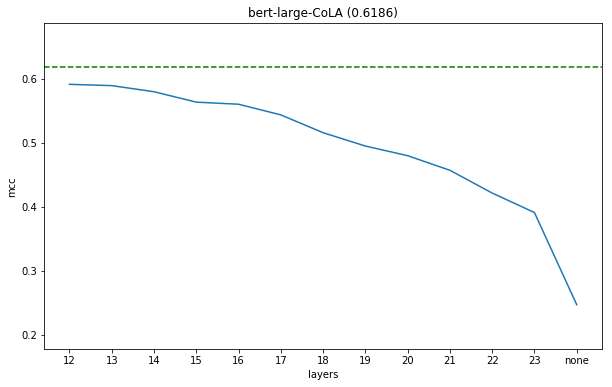


SST-2 acc 93.41 93.33 87.79



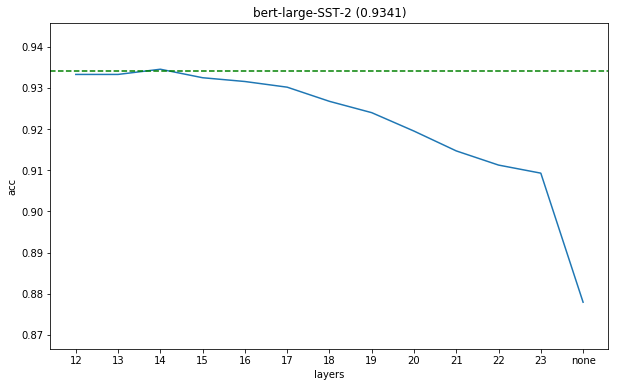


MRPC f1 90.34 88.9 81.34



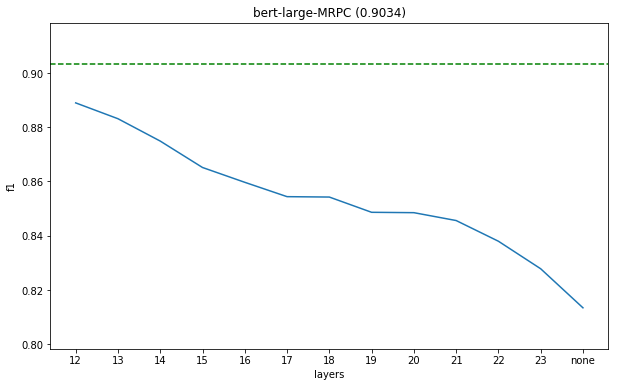


STS-B spearmanr 89.77 89.03 71.57



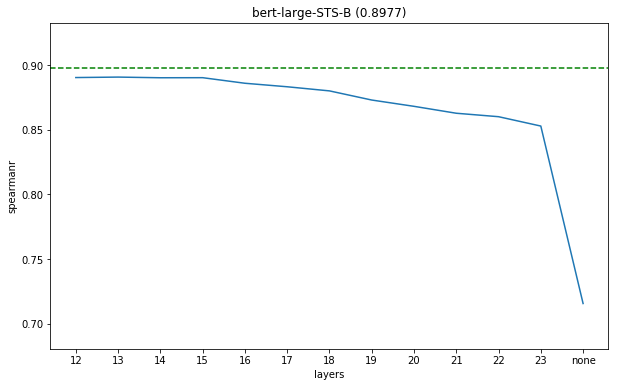


QQP f1 88.33 87.48 70.81



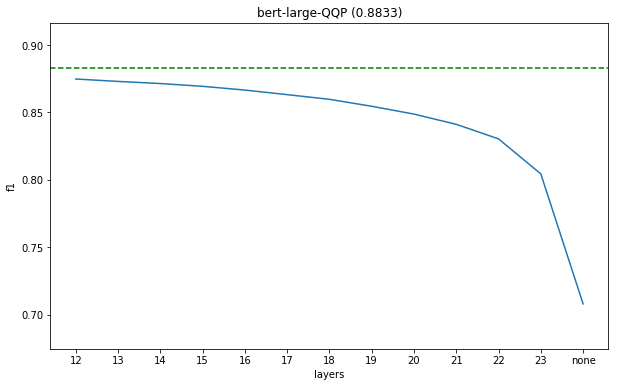


MNLI acc 86.35 86.25 58.87



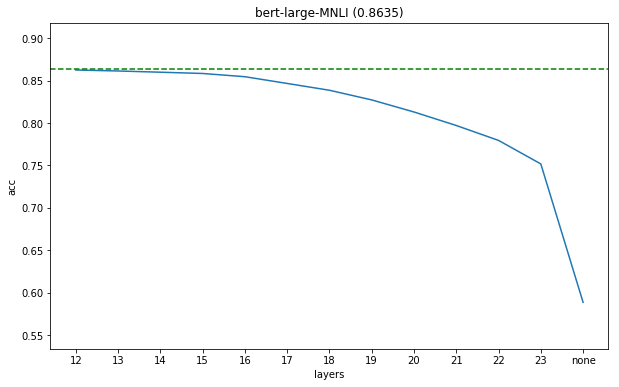


MNLI-MM acc 86.16 85.93 60.23



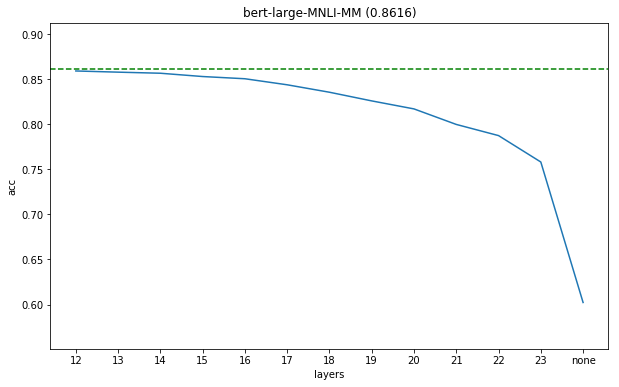


QNLI acc 92.23 92.25 74.84



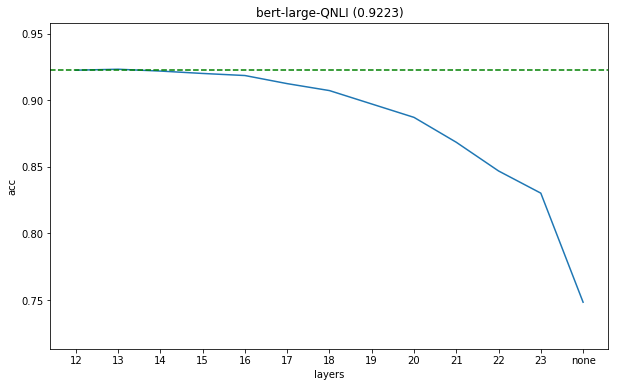


RTE acc 72.27 71.6 56.43



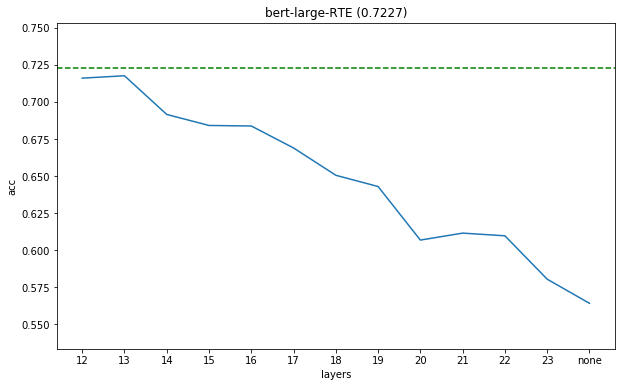

In [54]:
for task in tasks:
    task_results = results[task]
    task_metrics = metrics[task]
    for metric in task_metrics:
        reported = task_results[metric]
        base = task_results[f'base-{metric}']
        print_bold(task, metric, round(base * 100, 2), round(task_results[metric][0] * 100, 2), round(task_results[metric][-1] * 100, 2))
        draw_graph(task, metric, reported_in_paper[task], base, reported)